# Libs

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit

In [2]:
import sklearn
sklearn.__version__

'1.5.1'

# hw1

In [3]:
# В этом задании вам нужно проследить за изменением качества случайного леса в зависимости от количества деревьев в нем.

# Загрузите данные из файла abalone.csv. Это датасет, в котором требуется предсказать возраст ракушки (число колец) по физическим измерениям.

# Преобразуйте признак Sex в числовой: значение F должно перейти в -1, I — в 0, M — в 1. Если вы используете Pandas, 
# то подойдет следующий код: data['Sex'] = data['Sex'].map(lambda x: 1 if x == 'M' else (-1 if x == 'F' else 0))

# Разделите содержимое файлов на признаки и целевую переменную. В последнем столбце записана целевая переменная, в остальных — признаки.

# Обучите случайный лес (sklearn.ensemble.RandomForestRegressor) с различным числом деревьев: от 1 до 50 (не забудьте выставить 
# "random_state=1" в конструкторе). Для каждого из вариантов оцените качество работы полученного леса на кросс-валидации по 5 блокам. 
# Используйте параметры "random_state=1" и "shuffle=True" при создании генератора кросс-валидации sklearn.model_selection.KFold.  
# В качестве меры качества воспользуйтесь коэффициентом детерминации (sklearn.metrics.r2_score).

# Определите, при каком минимальном количестве деревьев случайный лес показывает качество на кросс-валидации выше 0.52. 
# Это количество и будет ответом на задание.

# Обратите внимание на изменение качества по мере роста числа деревьев. Ухудшается ли оно?

In [4]:
df = pd.read_csv('abalone.csv')
df['Sex'] = df['Sex'].map(lambda x: 1 if x == 'M' else (-1 if x == 'F' else 0))
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])

In [5]:
for n_estim in range(1, 51):
    model = RandomForestRegressor(n_estimators=n_estim)
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    r2_scores = []
    for k, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)
        r2_scores.append(score)
    avg_r2_score = np.mean(r2_scores)
    print(f'Number of estimators: {n_estim}, Average R2 Score: {avg_r2_score}')
    if avg_r2_score > 0.52:
        break

Number of estimators: 1, Average R2 Score: 0.08335168375920435
Number of estimators: 2, Average R2 Score: 0.3269534732940834
Number of estimators: 3, Average R2 Score: 0.4051068143516193
Number of estimators: 4, Average R2 Score: 0.4422438107254859
Number of estimators: 5, Average R2 Score: 0.4519613482963166
Number of estimators: 6, Average R2 Score: 0.47125676327389626
Number of estimators: 7, Average R2 Score: 0.4765407634813644
Number of estimators: 8, Average R2 Score: 0.4823999065481102
Number of estimators: 9, Average R2 Score: 0.4894356640226075
Number of estimators: 10, Average R2 Score: 0.5039276698000601
Number of estimators: 11, Average R2 Score: 0.49795256316194936
Number of estimators: 12, Average R2 Score: 0.4961579790374676
Number of estimators: 13, Average R2 Score: 0.5081858758311352
Number of estimators: 14, Average R2 Score: 0.5008815567488909
Number of estimators: 15, Average R2 Score: 0.5038720703996141
Number of estimators: 16, Average R2 Score: 0.509329896908909

In [6]:
df_lst = []
for n_estim in tqdm(range(1, 51)):
    clf = RandomForestRegressor(n_estimators=n_estim)
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(clf, X, y, cv=kf, scoring='r2')
    df = pd.DataFrame({'n_estimatoes':n_estim, 'r2':scores.mean()}, index=[0])
    df_lst.append(df)
df = pd.concat(df_lst).reset_index(drop=True)

100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


In [7]:
# Правильный ответ 24
df_v2 = df.sort_values('r2', ascending=False)
df_v2[df_v2['r2'] >= 0.52].sort_values('n_estimatoes')

,n_estimatoes,r2
21,22,0.525165
22,23,0.522148
24,25,0.526911
25,26,0.524174
26,27,0.520935
27,28,0.525033
28,29,0.525548
29,30,0.523674
30,31,0.526747
31,32,0.526708


# hw2

In [8]:
# Инструкция по выполнению
# 1. Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). 
# В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные 
# характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split 
# с параметрами test_size = 0.8 и random_state = 241. 

# 2. Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения 
# learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:

# - Используйте метод staged_decision_function для предсказания качества на обучающей и тестовой выборке на каждой итерации.

# - Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле 1 / (1 + e^{−y_pred}), где y_pred — предсказанное значение.

# Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции sklearn.metrics.log_loss) на обучающей и тестовой выборках, 
# а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.

# 3. Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? 
# В ответе укажите одно из слов overfitting либо underfitting.

# 4. Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

# 5. На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество 
# у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается 
# у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно)

# Если ответом является нецелое число, то целую и дробную часть необходимо разграничивать точкой, например, 0.42. При необходимости округляйте дробную часть до двух знаков.

# Обратите внимание, что, хотя в градиентного бустинге гораздо более слабые базовые алгоритмы, он выигрывает у случайного леса благодаря более 
# "направленной" настройке — каждый следующий алгоритм исправляет ошибки имеющейся композиции. Также он обучается быстрее случайного леса благодаря 
# использованию неглубоких деревьев. В то же время, случайный лес может показать более высокое качество при неограниченных ресурсах — так, он выиграет 
# у градиентного бустинга на наших данных, если увеличить число деревьев до нескольких сотен (проверьте сами!).

In [10]:
df = pd.read_csv('gbm-data.csv')
y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [12]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1, random_state=241)
model.fit(X_train, y_train)

decision_function_lst = []
for decision_function in model.staged_decision_function(X_test):
    decision_function_lst.append(decision_function)
func = 1 / (1 + np.exp(-1*decision_function[-1]))
y_pred_proba = expit(decision_function[-1])

In [13]:
# Чтобы была возможность оценить качество построенной композиции на каждой итерации, у класса есть метод 
# staged_decision_function. Для заданной выборки он возвращает ответ на каждой итерации.
# Метрика log-loss реализована в пакете metrics: sklearn.metrics.log_loss. 
# Заметим, что данная метрика предназначена для классификаторов, выдающих оценку принадлежности классу, а не бинарные ответы
df_lst_test, df_lst_train, des_func_df_test, des_func_df_train = [], [], [], []
for lr in tqdm([1, 0.5, 0.3, 0.2, 0.1]):
# for lr in tqdm([1]):
    model = GradientBoostingClassifier(n_estimators=250, learning_rate=lr, random_state=241)
    model.fit(X_train, y_train)

    decision_function_lst_train, func_lst_train = [], []
    for decision_function_train in model.staged_decision_function(X_train):
        y_pred_proba = expit(decision_function_train[-1])
        func = 1 / (1 + np.exp(-1*decision_function_train[-1]))
        decision_function_lst_train.append(y_pred_proba[-1])
        func_lst_train.append(func[-1])
    des_func_df_train.append(pd.DataFrame({'lr':lr, 'decision_function':decision_function_lst_train, 'func':func_lst_train}))

    decision_function_lst_test, func_lst_test = [], []
    for decision_function_test in model.staged_decision_function(X_test):
        y_pred_proba = expit(decision_function_test[-1])
        func = 1 / (1 + np.exp(-1*decision_function_test[-1]))
        decision_function_lst_test.append(y_pred_proba[-1])
        func_lst_test.append(func[-1])
    des_func_df_test.append(pd.DataFrame({'lr':lr, 'decision_function':decision_function_lst_test, 'func':func_lst_test}))

    # Calculate log loss for each iteration
    log_losses_train = []
    for y_pred_proba_train in model.staged_predict_proba(X_train):
        loss_train = log_loss(y_train, y_pred_proba_train)
        log_losses_train.append(loss_train)
    df_lst_train.append(pd.DataFrame({'lr':lr, 'log_loss':log_losses_train}))

    log_losses_test = []
    for y_pred_proba_test in model.staged_predict_proba(X_test):
        loss_test = log_loss(y_test, y_pred_proba_test)
        log_losses_test.append(loss_test)
    df_lst_test.append(pd.DataFrame({'lr':lr, 'log_loss':log_losses_test}))
df_test = pd.concat(df_lst_test)
df_test['type'] = 'test'
df_train = pd.concat(df_lst_train)
df_train['type'] = 'train'
df = pd.concat([df_test, df_train])
dec_func_train = pd.concat(des_func_df_train)
dec_func_test = pd.concat(des_func_df_test)
dec_func_train['type'] = 'train'
dec_func_test['type'] = 'test'
dec_func = pd.concat([dec_func_train, dec_func_test])

100%|██████████| 5/5 [00:51<00:00, 10.27s/it]


In [14]:
df[df.type=='train'].sort_values('log_loss', ascending=True).head(3)

,lr,log_loss,type
249,1.0,0.000017,train
248,1.0,0.000018,train
247,1.0,0.000018,train


In [15]:
df[df.type=='test'].sort_values('log_loss', ascending=True).head(3)

,lr,log_loss,type
51,0.1,0.525907,test
50,0.1,0.526075,test
52,0.1,0.526299,test


In [25]:
df_02 = df[df.lr==0.2]
df_02.sort_values('log_loss', ascending=True).round(2).head(3)

,lr,log_loss,type
249,0.2,0.02,train
248,0.2,0.03,train
247,0.2,0.03,train


In [26]:
df_02 = df[df.lr==0.2]
df_02[df_02.type=='test'].sort_values('log_loss', ascending=True).round(2).head(3)

,lr,log_loss,type
36,0.2,0.53,test
38,0.2,0.53,test
37,0.2,0.53,test


In [28]:
df_02[df_02.type=='test']

,lr,log_loss,type
0,0.2,0.644018,test
1,0.2,0.611680,test
2,0.2,0.590484,test
3,0.2,0.576736,test
4,0.2,0.563464,test
...,...,...,...
245,0.2,0.654809,test
246,0.2,0.655795,test
247,0.2,0.656527,test
248,0.2,0.656843,test


<Axes: xlabel='None', ylabel='func'>

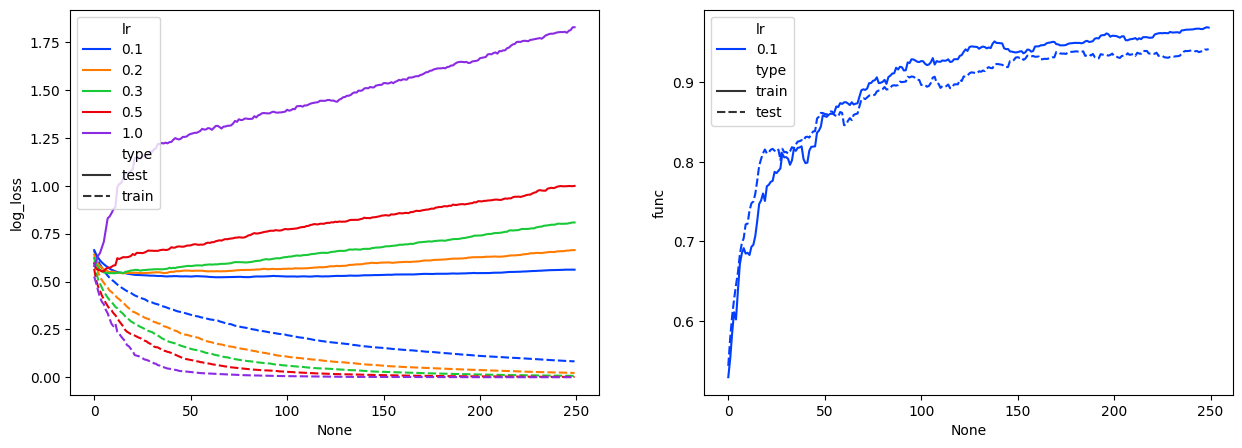

In [ ]:
# Training vs. Testing Log Loss: It's important to compare the log_loss on both the training and testing datasets. 
# A significantly lower log_loss on the training set compared to the testing set may indicate overfitting.

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=df, x=df.index, y='log_loss', hue='lr', style='type', palette='bright', ax=ax[0])
sns.lineplot(data=dec_func, x=dec_func.index, y='func', hue='lr', style='type', palette='bright', ax=ax[1])
# sns.lineplot(data=dec_func, x=dec_func.index, y='decision_function', hue='lr', ls='-.', palette='bright', ax=ax[1])

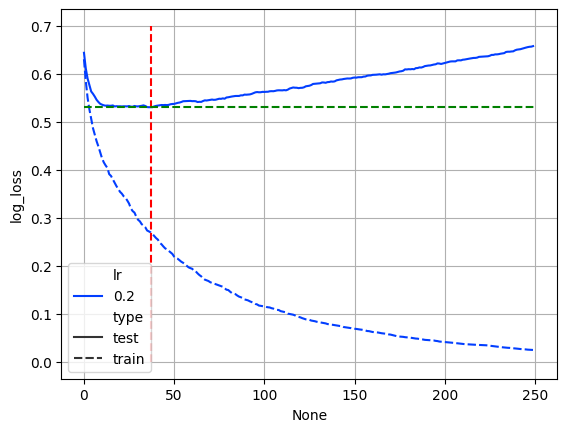

In [ ]:
sns.lineplot(data=df_02, x=df_02.index, y='log_loss', hue='lr', style='type', palette='bright')
plt.vlines(x=37, ymin=0, ymax=0.7, color='red', ls='--')
plt.hlines(y=0.530633, xmin=0, xmax=250, color='green', ls='--')
plt.grid()

In [ ]:
# 5. На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество 
# у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается 
# у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно)

In [ ]:
# df_rfc_lst = []
# for i in tqdm(range(1, 250)):
model = RandomForestClassifier(n_estimators=37, random_state=241)
model.fit(X_train, y_train)
loss_train = log_loss(y_train, model.predict_proba(X_train))
loss_test = log_loss(y_test, model.predict_proba(X_test))
    # print(f'Number of estimators: {i}, Log Loss Train: {loss_train}, Log Loss Test: {loss_test}')
    # df_rfc = pd.DataFrame({'n_estimators':i, 'log_loss_train':loss_train, 'log_loss_test':loss_test}, index=[0])
    # df_rfc_lst.append(df_rfc)
# df_rfc = pd.concat(df_rfc_lst).reset_index(drop=True)

In [ ]:
loss_test